# Simplified model for UHECR data

Here we use a simplified version of the model described in *Soiaporn, K. et al., 2012. Multilevel Bayesian framework for modeling the production, propagation and detection of ultra-high energy cosmic rays. arXiv.org, astro-ph.HE(3), pp.1249–1285* and summarised in soiaporn_model.ipynb to generate simulated data for the UHECR arrival directions.


A generative model is built here to simulate datasets and test the fit for known parameters. 

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
from matplotlib import pyplot as plt
import numpy as np
from fancy import *

In [2]:
# read in relevant data
source_file = 'data/agn_catalog.dat'

# define a Data() instance to handle all data
data = Data()

# add the AGN data
data.add_source(source_file, 'AGN')

## Sources

For the most basic model start with just the sources and no dtection effects. The source distribution is defined by the luminosity function $(F_T, f)$ and the hyperparameters $s$, $a$ and $b$:

<div><center>
$ g(F_T) = \frac{1}{s}e^{-F_T/s}$
<center></div>
<div><center>
$ h(f) = \frac{1}{B(a,b)}f^{a-1}(1-f)^{b-1}$
<center></div>

With s = $0.01 \times 4\pi$, and a = b = 1.
We have the *luminosity function* of a standard candle: $F_k = I/D_k^2$, but we choose instead to represent I through the total source flux: $ F_A = \sum_{k=1}^{N_A} $. So, $F_k = w_kF_A$ with the weights $w_k = \frac{1/D_k^2}{\sum_{j=1}^{N_A} 1/D_j^2}$. 

For now we set the total integrated flux to 500 events, to be distributed amongst the sources depending on their distance from Earth.

The associated fraction is 1 for now, for simplicity. So, all events are associated with the 17 AGN in the sample.

We have:

* $F_T = 500$
* $f = 1$

In [3]:
# set source parameters
F_T = 500 # total flux
f = 1 # associated fraction
F_A = f * F_T # source flux

In [4]:
# use this model to generate simulated data from the given AGN sources
# distances to AGN
D = data.source['AGN'].distance
# number of AGN
N_A = len(D) 

# function to calculate the weights
def get_weights(D):
    normalisation = 0
    for D_j in D:
        normalisation += (1 / D_j**2)  
    
    w = []
    for D_k in D:
        w.append( (1 / D_k**2) / normalisation)
    w = np.asarray(w)
    return w

# how many events to simulate for each source?
w = get_weights(D)
F = []
for w_k in w:
    F.append(int(round(w_k * F_T)))
print ('Total flux:', sum(F))

Total flux: 497


## Propagation

Due to magnetic fields, the UHECR trajectories are deflected. For a simple model, this deflection can de described by a von Mises - Firsher distribution:

<div><center>
$\rho_k(\omega | \kappa) = \frac{\kappa}{4\pi sinh(\kappa)}e^{\kappa \omega . \varpi_k}$    
<center></div>

Where:

* $\kappa$ is the concentration parameter
* $\omega$ is the UHECR direction
* $\varpi_k$ is the source direction

Here, we set the concentration parameter to be $\kappa = 100$

In [5]:
# set the propagation parameter
kappa = 5

In [6]:
from astropy.coordinates import SkyCoord
from astropy import units as u

# first try with a 2D gaussian instead of the vMF
# work directly with the galactic coordinates
# standard deviation defintiion
std = 20 # deg

varpi = data.source['AGN'].coord

# funciton to handle wrapping for lats and lons
def wrap(input, limit):
    if limit == 90:
        if input > limit:
            output = input - (2 * limit)
        elif input < -limit:
            output = input + (2 * limit) 
        else: output = input
    elif limit == 360:
        if input > limit:
            output = input - limit
        elif input < 0:
            output = limit + input
        else:
            output = input
    return output
    
omega = []
for i in range(N_A):
    N = F[i]
    mu_lon = varpi.galactic.l.deg[i]
    mu_lat = varpi.galactic.b.deg[i]
    sample_lon = np.random.normal(mu_lon, std, N)
    for j in range(len(sample_lon)):
        sample_lon[j] = wrap(sample_lon[j], 360)
    sample_lat = np.random.normal(mu_lat, std, N)
    for j in range(len(sample_lat)):
        sample_lat[j] = wrap(sample_lat[j], 90)
    sample_coord = SkyCoord(l = sample_lon * u.deg, b = sample_lat * u.deg,
                           frame = 'galactic')
    omega.append(sample_coord)


/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


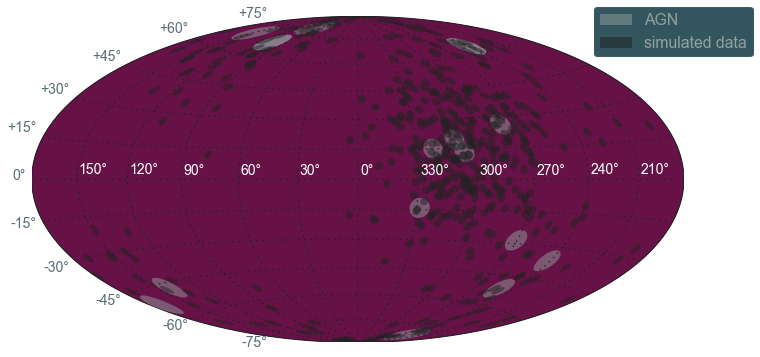

In [7]:
# plot the results on a skymap
fig, skymap = data.show()
label = True
for o in omega:
    for lon, lat in np.nditer([o.galactic.l.deg, o.galactic.b.deg]):
        if label:
            skymap.tissot(lon, lat, 2, npts = 30, facecolor = 'k', alpha = 0.5, 
                          label = 'simulated data')
            label = False
        else:
            skymap.tissot(lon, lat, 2, npts = 30, facecolor = 'k', alpha = 0.5)

plt.gca()
plt.legend(bbox_to_anchor=(0.85, 0.85))

In [8]:
from vMF import *
from astropy.coordinates import SkyCoord
from astropy import units as u

# Now try with the vMF distribution 
# get the positions of the sources
skycoords = data.source['AGN'].coord

# convert to cartesian coordinates
varpi = [skycoords.cartesian.x, skycoords.cartesian.y, skycoords.cartesian.z] 
varpi = np.transpose(varpi)

# Make a wapper class to store output
class Direction():
    """
    Input the de-normalised vMF samples and 
    store x, y, and z and galactic coordinates 
    of direction in Mpc.
    """
    
    def __init__(self, omega_k):
        self.x = np.transpose(omega_k)[0]
        self.y = np.transpose(omega_k)[1] 
        self.z = np.transpose(omega_k)[2] 
        self.d = SkyCoord(self.x, self.y, self.z, 
                          unit = 'mpc', 
                          representation_type = 'cartesian', 
                          frame = 'galactic')
        self.d.representation_type = 'spherical'
        self.lons = self.d.galactic.l.wrap_at(360 * u.deg).deg
        self.lats = self.d.galactic.b.wrap_at(180 * u.deg).deg
        
# simulate events
omega = []
for i in range(N_A):
    N = F[i]
    # normalise to unit sphere for sampling, then revert
    norm = np.linalg.norm(varpi[i])
    mu = varpi[i] / norm
    omega_k = (sample_vMF(mu, kappa, N)) * norm
    omega.append(Direction(omega_k))

/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


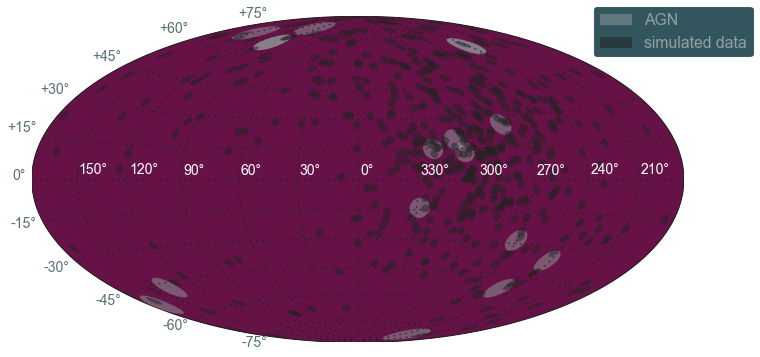

In [9]:
# plot the results on a skymap
fig, skymap = data.show()
label = True
for o in omega:
    for lon, lat in np.nditer([o.lons, o.lats]):
        if label:
            skymap.tissot(lon, lat, 2, npts = 30, facecolor = 'k', alpha = 0.5, 
                          label = 'simulated data')
            label = False
        else:
            skymap.tissot(lon, lat, 2, npts = 30, facecolor = 'k', alpha = 0.5)

plt.gca()
plt.legend(bbox_to_anchor=(0.85, 0.85))

## Detection effects

The arrival direction of UHECR is reconstructed with a certain uncertainty by the PAO team. This is quantified here by the von Mises-Fisher distribution for the data:

<div><center>
$P(d_i | \omega_i) = \frac{\kappa}{4\pi sinh(\kappa)}e^{\kappa d_i \omega_i}$    
<center></div>

We can sample from this distibrution, assuming the true arrival direction is a certain source. For now we leave out the detection effects for simplicity.

## Fitting the model in Stan

The Stan model is written up in `simplified_model.stan`. For the fit, we don't need to have the UHECR directions in galactic coordinates. 
